In [5]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib
from matplotlib import pyplot as plt
import os
import pathlib
from pathlib import Path
import numpy as np
from IPython.display import display
from IPython.display import Audio
from IPython.core.display import display

C:\Users\shubh\AppData\Local\Temp\ipykernel_22924\3659903053.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [6]:
#YES_AUDIO = os.path.join("C:/Users/shubh/Desktop/Btech/MINI PROJECT/Voice Automation/Dataset/yes/0bac8a71_nohash_0.wav")

In [7]:
def mono_16k(wav, labels):
    #file_contents = tf.io.read_file(file_path)
    #wav ,sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
    wav = tf.squeeze(wav, axis = -1)
    #sample_rate = tf.cast(sample_rate, dtype= tf.int64)
    #wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
    return wav, labels


In [8]:
data_dir = Path("C:/Users/shubh/OneDrive/Desktop/eveythingeverywhereallatonce/Btech/MINI PROJECT/Voice Automation/Dataset")
commands = np.array(os.listdir(str(data_dir)))
print("COMMANDS :", commands)

COMMANDS : ['down' 'go' 'left' 'marvin' 'no' 'off' 'on' 'one' 'right' 'stop' 'up'
 'yes' 'zero']


In [9]:
train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory  = data_dir,
    #labels='inferred',
    #class_names=None,
    batch_size = 64,
    seed = 0,
    validation_split = 0.25,
    subset = "both",
    output_sequence_length = 16000
)

Found 48588 files belonging to 13 classes.
Using 36441 files for training.
Using 12147 files for validation.


In [10]:
labels_list = np.array(train_data.class_names)
print(labels_list)

['down' 'go' 'left' 'marvin' 'no' 'off' 'on' 'one' 'right' 'stop' 'up'
 'yes' 'zero']


In [11]:
train_data.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [12]:
train_data = train_data.map(mono_16k, tf.data.AUTOTUNE)
test_data = test_data.map(mono_16k, tf.data.AUTOTUNE)

In [13]:
for x_audio, x_label in train_data.take(1):
    print(x_audio.shape)
    print(x_label.shape)
    

(64, 16000)
(64,)


In [14]:
waves = train_data.as_numpy_iterator().next()

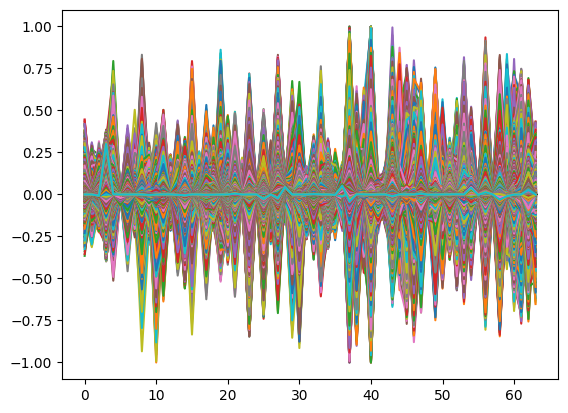

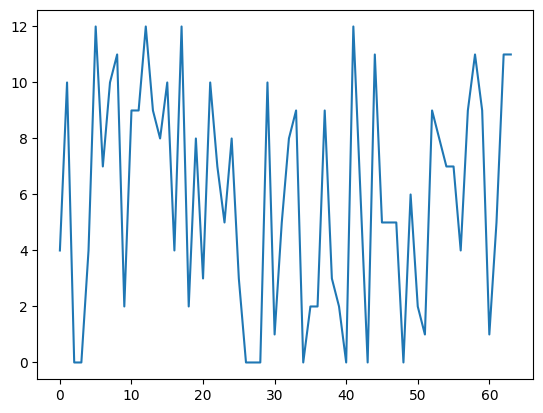

In [15]:
for wave in waves:
    
    plt.plot(wave)
    plt.show()

In [16]:
def make_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis =2)
    return spectrogram

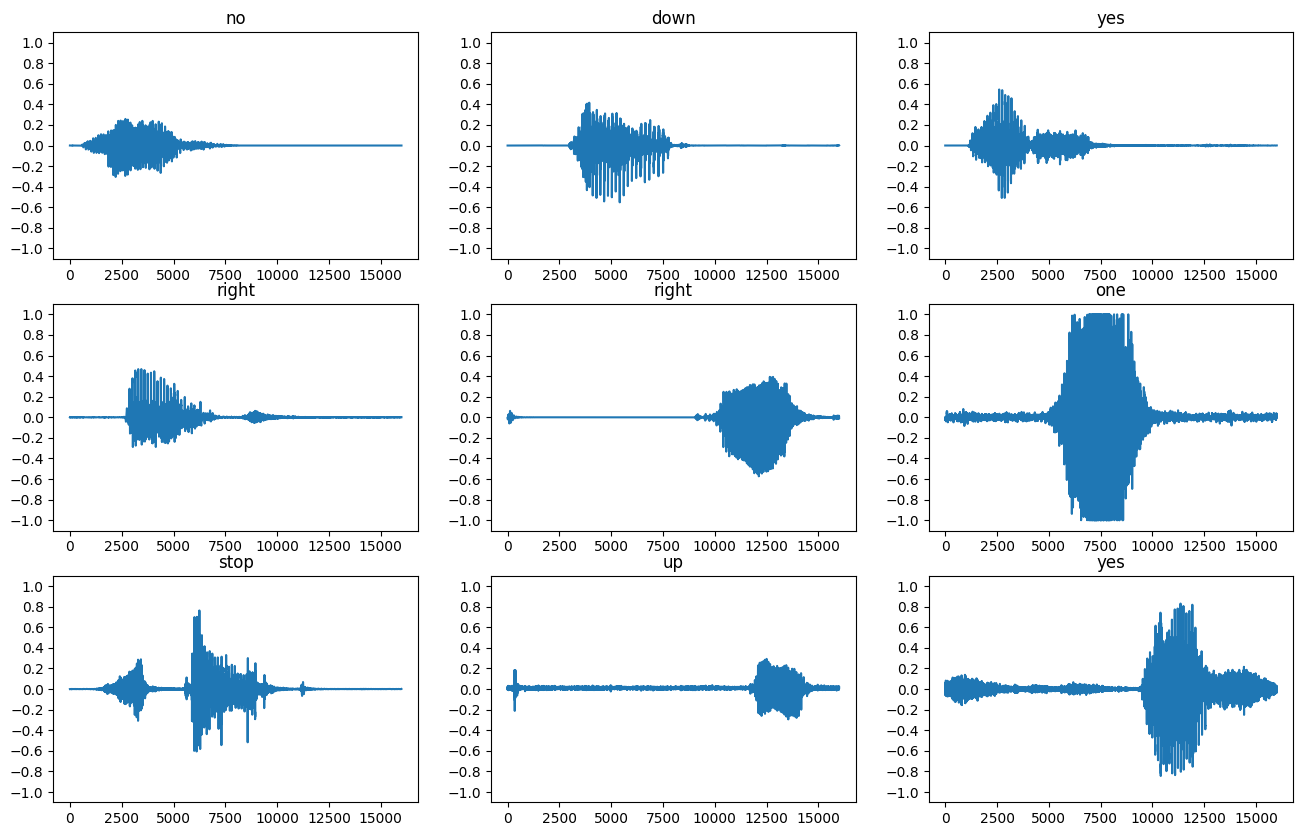

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = x_audio[i]
  plt.plot(audio_signal)
  plt.title(labels_list[x_label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [18]:
for i in range(4):
  label = labels_list[x_label[i]]
  waveform = x_audio[i]
  spectrogram = make_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


In [19]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

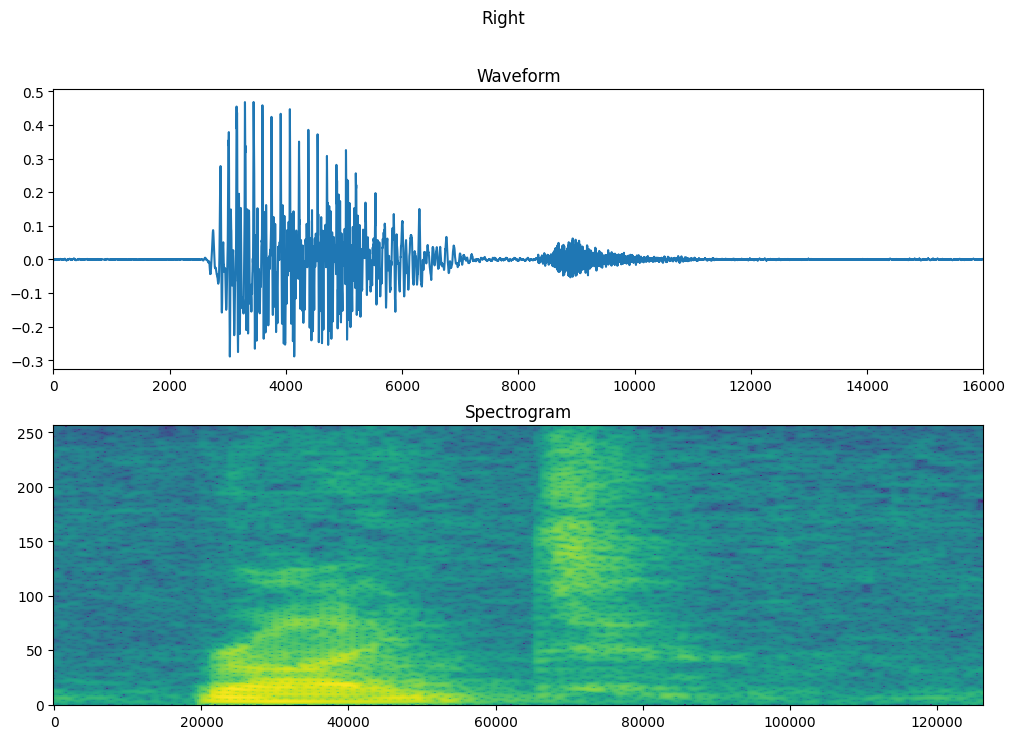

In [20]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [21]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (make_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_spectrogram_ds = make_spec_ds(train_data)
test_spectrogram_ds = make_spec_ds(test_data)

In [23]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

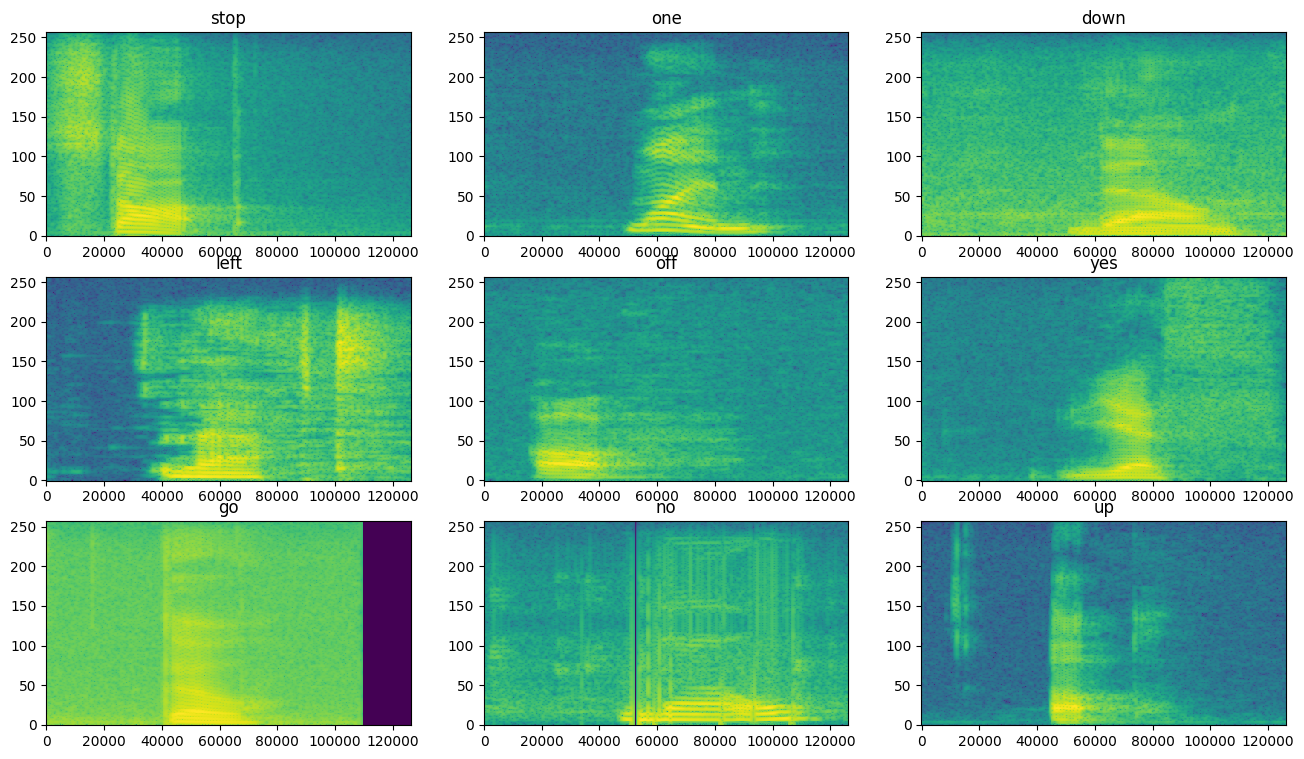

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels_list[example_spect_labels[i].numpy()])

plt.show()

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_list)


norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    
    layers.Resizing(32, 32),
    
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (491, 1, 257)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 257)       0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 257)       515       
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        74048     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                          

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [28]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data= (test_spectrogram_ds),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
570/570 [==============================] - 590s 1s/step - loss: 1.4054 - accuracy: 0.5531 - val_loss: 0.6658 - val_accuracy: 0.7925
Epoch 2/10
570/570 [==============================] - 581s 1s/step - loss: 0.7547 - accuracy: 0.7714 - val_loss: 0.5299 - val_accuracy: 0.8400
Epoch 3/10
570/570 [==============================] - 570s 997ms/step - loss: 0.6562 - accuracy: 0.8061 - val_loss: 0.5617 - val_accuracy: 0.8340
Epoch 4/10
570/570 [==============================] - 598s 1s/step - loss: 0.6172 - accuracy: 0.8165 - val_loss: 0.4994 - val_accuracy: 0.8507
Epoch 5/10
570/570 [==============================] - 616s 1s/step - loss: 0.5766 - accuracy: 0.8295 - val_loss: 0.5183 - val_accuracy: 0.8601
Epoch 6/10
570/570 [==============================] - 589s 1s/step - loss: 0.5334 - accuracy: 0.8432 - val_loss: 0.4671 - val_accuracy: 0.8694
Epoch 7/10
570/570 [==============================] - 1346s 2s/step - loss: 0.5150 - accuracy: 0.8502 - val_loss: 0.4811 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy [%]')

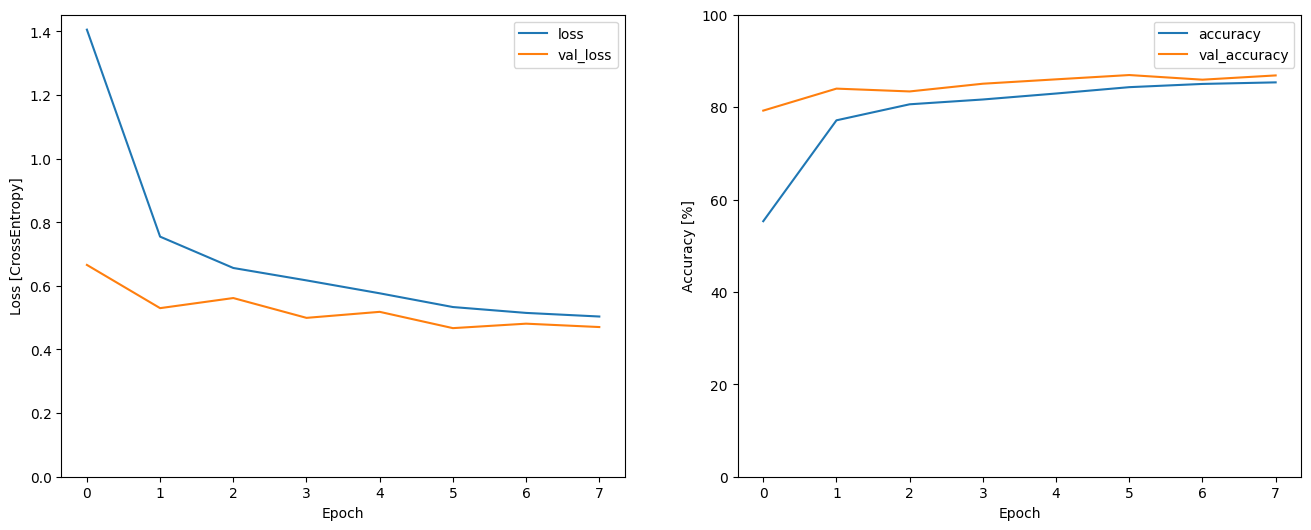

In [30]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [31]:
model.evaluate(test_spectrogram_ds, return_dict=True)

190/190 [==============================] - 56s 289ms/step - loss: 0.4705 - accuracy: 0.8686


{'loss': 0.4705158770084381, 'accuracy': 0.8686095476150513}

In [32]:
#model.save("VOICE_NEW",save_format='h5')

c:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
